<a href="https://colab.research.google.com/github/mons-trev/Generative_AI_research/blob/main/test/CompVis_latent_imagenet_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Class-Conditional Synthesis with Latent Diffusion Models

# 로컬 코랩에서 돌아가도록 코드 수정
ddpm.py "from pytorch_lightning.utilities.rank_zero import rank_zero_only" 수정 필요

Install all the requirements

In [10]:
#@title Installation
!git clone https://github.com/CompVis/latent-diffusion.git
!git clone https://github.com/CompVis/taming-transformers
!pip install -e ./taming-transformers
!pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops

import sys
sys.path.append(".")
sys.path.append('./taming-transformers')


Cloning into 'latent-diffusion'...
remote: Enumerating objects: 341, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 341 (delta 116), reused 107 (delta 107), pack-reused 169
Receiving objects: 100% (341/341), 28.69 MiB | 29.73 MiB/s, done.
Resolving deltas: 100% (148/148), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 1342 (delta 0), reused 1 (delta 0), pack-reused 1340
Receiving objects: 100% (1342/1342), 409.77 MiB | 44.77 MiB/s, done.
Resolving deltas: 100% (282/282), done.
Obtaining file:///content/latent-diffusion/latent-diffusion/taming-transformers
  Preparing metadata (setup.py) ... done
  Attempting uninstall: taming-transformers
    Found existing installation: taming-transformers 0.0.1
    Uninstalling taming-transformers-0.0.1:
      Successfully uninstalled taming

In [11]:
# Load and modify the taming-transformers code
file_path = './taming-transformers/taming/data/utils.py'

with open(file_path, 'r') as file:
    lines = file.readlines()

with open(file_path, 'w') as file:
    for line in lines:
        if 'from torch._six import string_classes' in line:
            file.write('import collections.abc\n')
            file.write('string_classes = (str, bytes)\n')
        elif 'from torch.utils.data._utils.collate import np_str_obj_array_pattern, default_collate_err_msg_format' in line:
            file.write('from torch.utils.data._utils.collate import default_collate_err_msg_format\n')
            file.write('np_str_obj_array_pattern = (str, bytes, collections.abc.Sequence)\n')
        else:
            file.write(line)

from taming.models import vqgan

Now, download the checkpoint (~1.7 GB). This will usually take 1-2 minutes.

In [12]:
#@title Download
%cd latent-diffusion/

!mkdir -p models/ldm/cin256-v2/
!wget -O models/ldm/cin256-v2/model.ckpt https://ommer-lab.com/files/latent-diffusion/nitro/cin/model.ckpt

/content/latent-diffusion/latent-diffusion/latent-diffusion
--2024-06-02 10:58:47--  https://ommer-lab.com/files/latent-diffusion/nitro/cin/model.ckpt
Resolving ommer-lab.com (ommer-lab.com)... 141.84.41.65
Connecting to ommer-lab.com (ommer-lab.com)|141.84.41.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1827378153 (1.7G)
Saving to: ‘models/ldm/cin256-v2/model.ckpt’

models/ldm/cin256-v 100%[===================>]   1.70G  29.5MB/s    in 62s     

2024-06-02 10:59:49 (28.2 MB/s) - ‘models/ldm/cin256-v2/model.ckpt’ saved [1827378153/1827378153]



Let's also check what type of GPU we've got.

In [13]:
!nvidia-smi

Sun Jun  2 10:59:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [14]:
!pip install git+https://github.com/openai/CLIP.git

# Step 1: 클론합니다
!git clone https://github.com/CompVis/latent-diffusion.git

# Step 2: 디렉토리로 이동합니다
%cd latent-diffusion

# Step 3: 필요한 의존성을 설치합니다
!pip install -e .


!pip install kornia


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-afzfsz53
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-afzfsz53
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
Cloning into 'latent-diffusion'...
remote: Enumerating objects: 341, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 341 (delta 116), reused 107 (delta 107), pack-reused 169
Receiving objects: 100% (341/341), 28.69 MiB | 18.36 MiB/s, done.
Resolving deltas: 100% (148/148), done.
/content/latent-diffusion/latent-diffusion/latent-diffusion/latent-diffusion
Obtaining file:///content/latent-diffusion/latent-diffusion/latent-diffusion/latent-diffusion
  Preparing metadata (setup.py) ... done
  Attempting uninstall: latent-diffusion
    Found existing installation: latent-diffusion 0.0.1
    Uninst

Load it.

In [22]:
#@title loading utils
import torch
from omegaconf import OmegaConf

from ldm.util import instantiate_from_config


def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt)#, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.cuda()
    model.eval()
    return model


def get_model():
    config = OmegaConf.load("configs/latent-diffusion/cin256-v2.yaml")
    model = load_model_from_config(config, "/content/latent-diffusion/models/ldm/cin256-v2/model.ckpt")
    return model

In [23]:
from ldm.models.diffusion.ddim import DDIMSampler

model = get_model()
sampler = DDIMSampler(model)

Loading model from /content/latent-diffusion/models/ldm/cin256-v2/model.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


And go. Quality, sampling speed and diversity are best controlled via the `scale`, `ddim_steps` and `ddim_eta` variables. As a rule of thumb, higher values of `scale` produce better samples at the cost of a reduced output diversity. Furthermore, increasing `ddim_steps` generally also gives higher quality samples, but returns are diminishing for values > 250. Fast sampling (i e. low values of `ddim_steps`) while retaining good quality can be achieved by using `ddim_eta = 0.0`.

rendering 6 examples of class '1' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


rendering 6 examples of class '187' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:10<00:00,  1.95it/s]


rendering 6 examples of class '448' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


rendering 6 examples of class '992' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


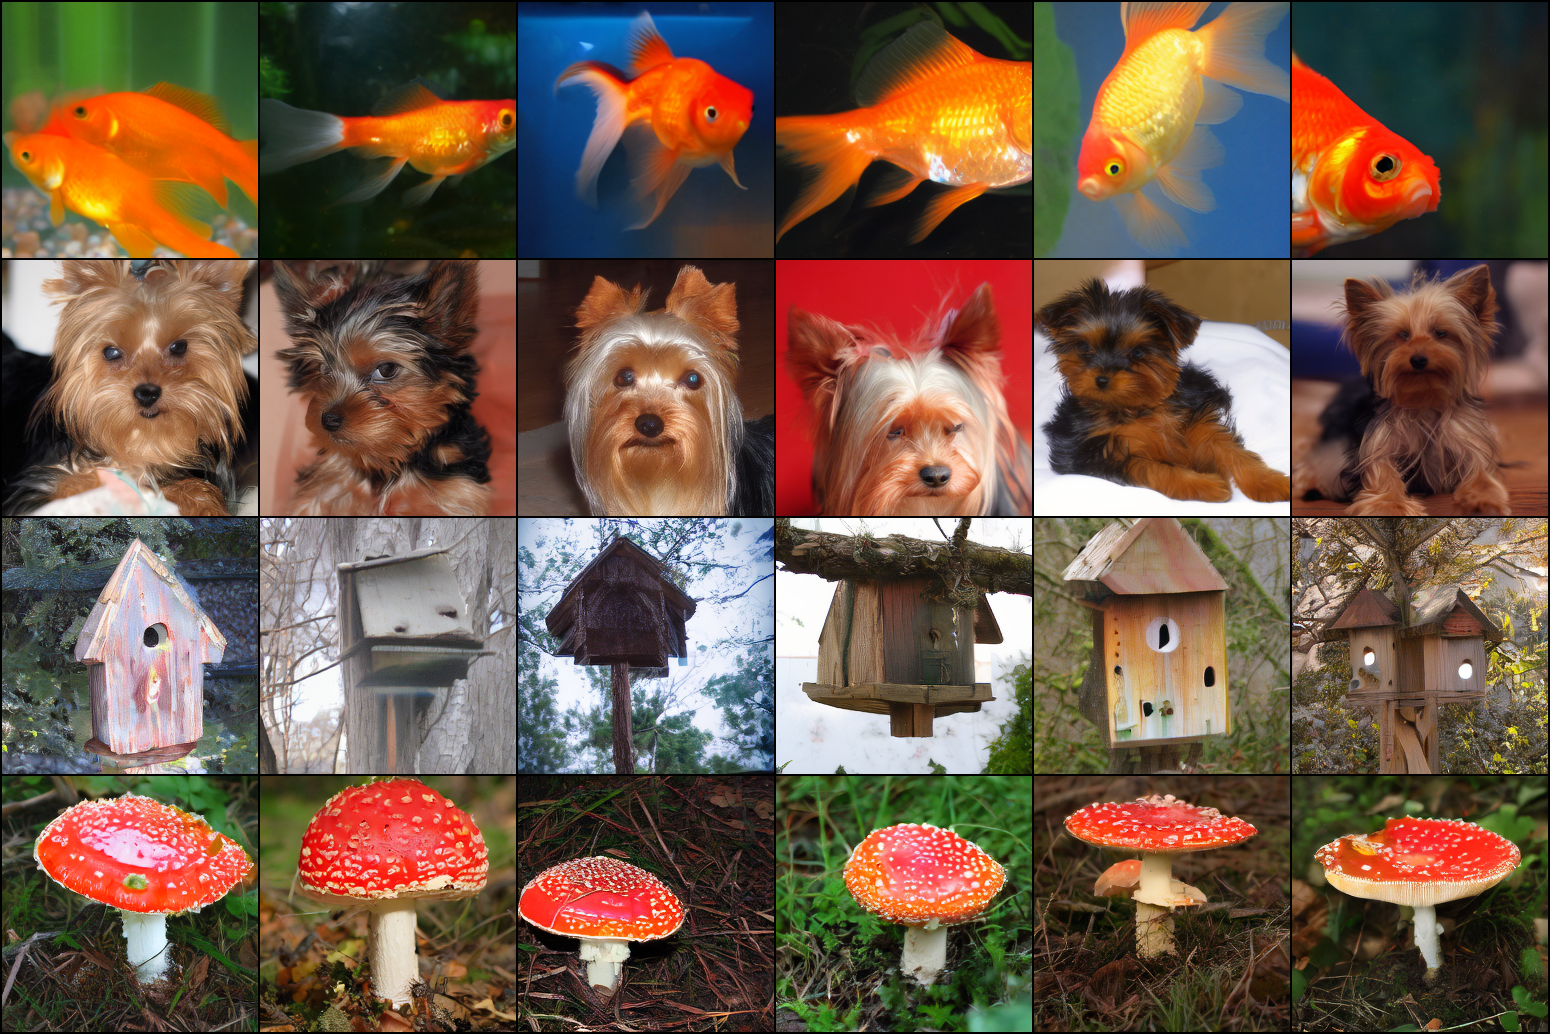

In [25]:
import numpy as np
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid


classes = [1, 187, 448, 992]   # define classes to be sampled here
n_samples_per_class = 6

ddim_steps = 20
ddim_eta = 0.0
scale = 3.0   # for unconditional guidance


all_samples = list()

with torch.no_grad():
    with model.ema_scope():
        uc = model.get_learned_conditioning(
            {model.cond_stage_key: torch.tensor(n_samples_per_class*[1000]).to(model.device)}
            )

        for class_label in classes:
            print(f"rendering {n_samples_per_class} examples of class '{class_label}' in {ddim_steps} steps and using s={scale:.2f}.")
            xc = torch.tensor(n_samples_per_class*[class_label])
            c = model.get_learned_conditioning({model.cond_stage_key: xc.to(model.device)})

            samples_ddim, _ = sampler.sample(S=ddim_steps,
                                             conditioning=c,
                                             batch_size=n_samples_per_class,
                                             shape=[3, 64, 64],
                                             verbose=False,
                                             unconditional_guidance_scale=scale,
                                             unconditional_conditioning=uc,
                                             eta=ddim_eta)

            x_samples_ddim = model.decode_first_stage(samples_ddim)
            x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0,
                                         min=0.0, max=1.0)
            all_samples.append(x_samples_ddim)


# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))